# Author -Kushal Das

### Stock Market Prediction using Numerical and Textual Analysis
- Create a hybrid model for stock price or performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. The stock to analyze and predict is SENSEX (S&P BSE SENSEX)

# Import the Important Libraries

In [102]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [4]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [7]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("/content/india-news-headlines.csv",names=columns)

In [8]:
print('Showing part of the whole dataset:')
ndf.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [9]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3876548,20230630,Yuri: We will question govt over sacking of un...
3876549,20230630,Three of family end lives due to financial burden
3876550,20230630,7;500 students with aptitude to learn advanced...
3876551,20230630,Civic bodies told to collect labour cess


In [10]:
# Load the second dataset
hisdf = pd.read_csv("^BSESN.csv")
hisdf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0
...,...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,46103.500000,20700.0


# Common Dataset Exploration

In [11]:
# Check for common information of the first datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3876557 entries, 1 to 3876557
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 59.2+ MB


In [12]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x))
ndf = ndf.drop_duplicates()
ndf.reset_index(inplace=True,drop=True)

In [13]:
ndf

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
8165,2023-06-26,How can loneliness worsen your mental health? ...
8166,2023-06-27,Daily Horoscope; June 27; 2023: Read your dail...
8167,2023-06-28,What is the 'courting hut' wedding ritual in A...
8168,2023-06-29,Daily Horoscope; June 29; 2023: Read your dail...


In [18]:
# Check for any duplicated values
ndf.isnull().sum()

,0
Date,0
News,0


In [19]:
len(ndf)

8170

In [20]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0
...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,20700.0


In [21]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.9 KB


In [22]:
hisdf.describe()

,Date,Open,High,Low,Close,Volume
count,252,250.000000,250.000000,250.000000,250.000000,250.000000
mean,2020-06-18 20:22:51.428571392,37804.237375,38071.182859,37422.826992,37745.454117,19134.000000
min,2019-12-17 00:00:00,26499.810547,27462.869141,25638.900391,25981.240234,0.000000
25%,2020-03-17 18:00:00,34369.659179,34779.932618,33975.389648,34257.097656,13125.000000
50%,2020-06-22 12:00:00,38489.480469,38750.359375,38234.869140,38425.974610,17000.000000
75%,2020-09-17 06:00:00,41179.222656,41376.482422,41023.923828,41135.233399,21075.000000
max,2020-12-17 00:00:00,46774.320313,46992.570313,46627.601563,46890.339844,188300.000000
std,NaN,4507.985769,4380.974060,4647.212947,4535.304336,16540.261333


In [23]:
# Check for duplicated values
hisdf.isnull().sum()

,0
Date,0
Open,2
High,2
Low,2
Close,2
Volume,2


In [24]:
len(hisdf)

252

Text(0, 0.5, 'BSESN')

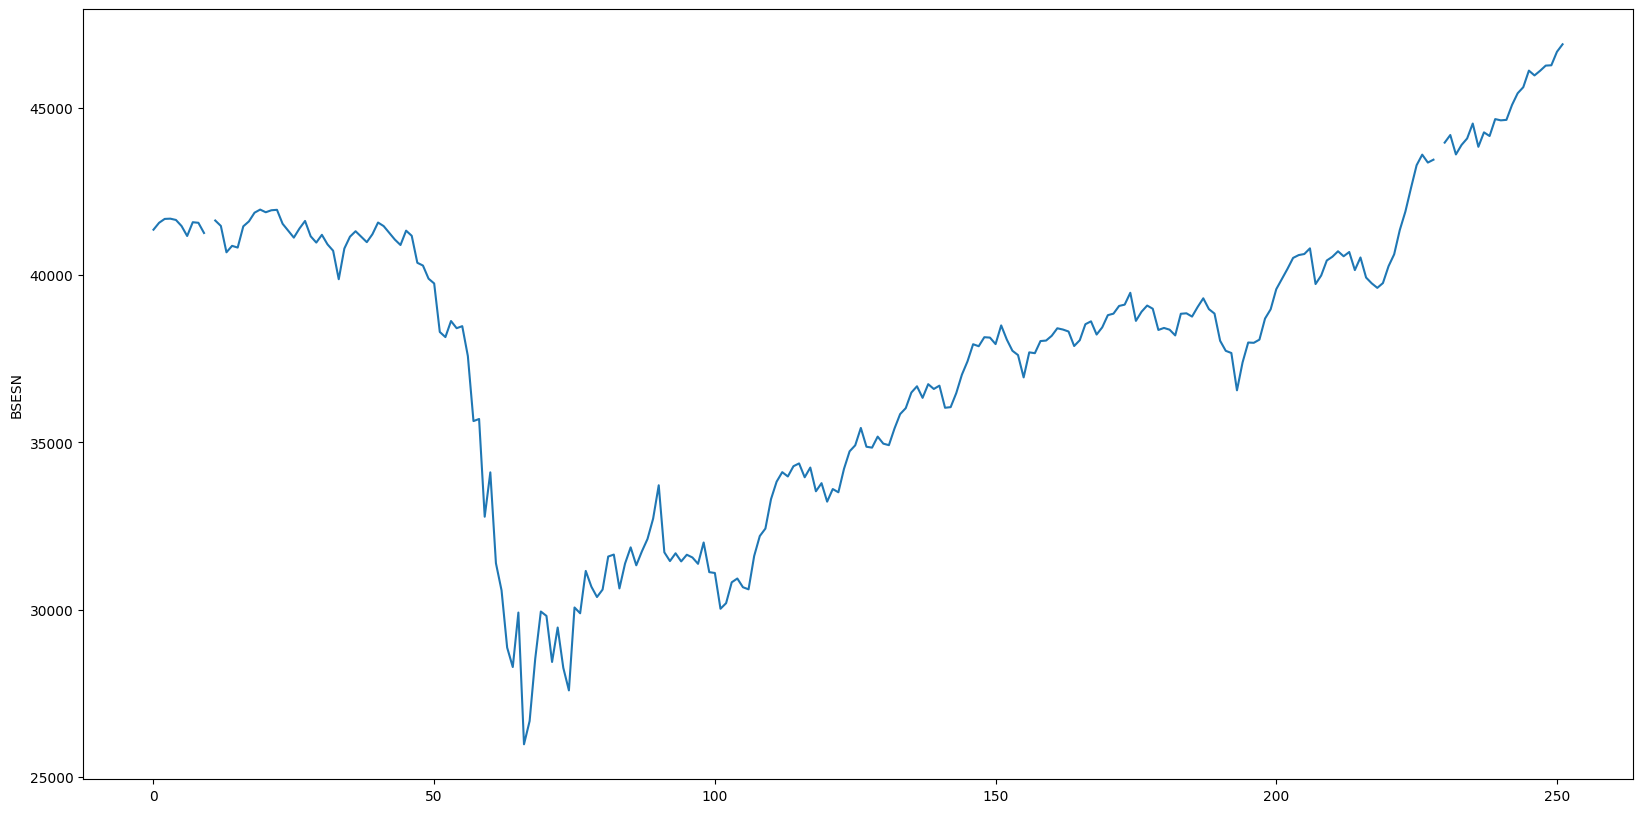

In [25]:
# Figure plot
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

# Remove Unwanted Characters from the News

In [77]:

import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [78]:
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [79]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess_headline(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs and email addresses
    text = text.replace(r'http\S+|www\S+|https\S+', '')
    text = text.replace(r'\@\w+', '')
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = text.replace(r'\d+', '')
    # Remove special characters and emojis
    text = text.replace(r'[^\x00-\x7F]+', '')
    # Remove stopwords and apply lemmatization
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    # Remove extra whitespaces
    text = text.strip()
    return text

# Apply preprocessing to the DataFrame
ndf["News"] = ndf["News"].apply(preprocess_headline)


# Historical Analysis

# Plot the Moving Average

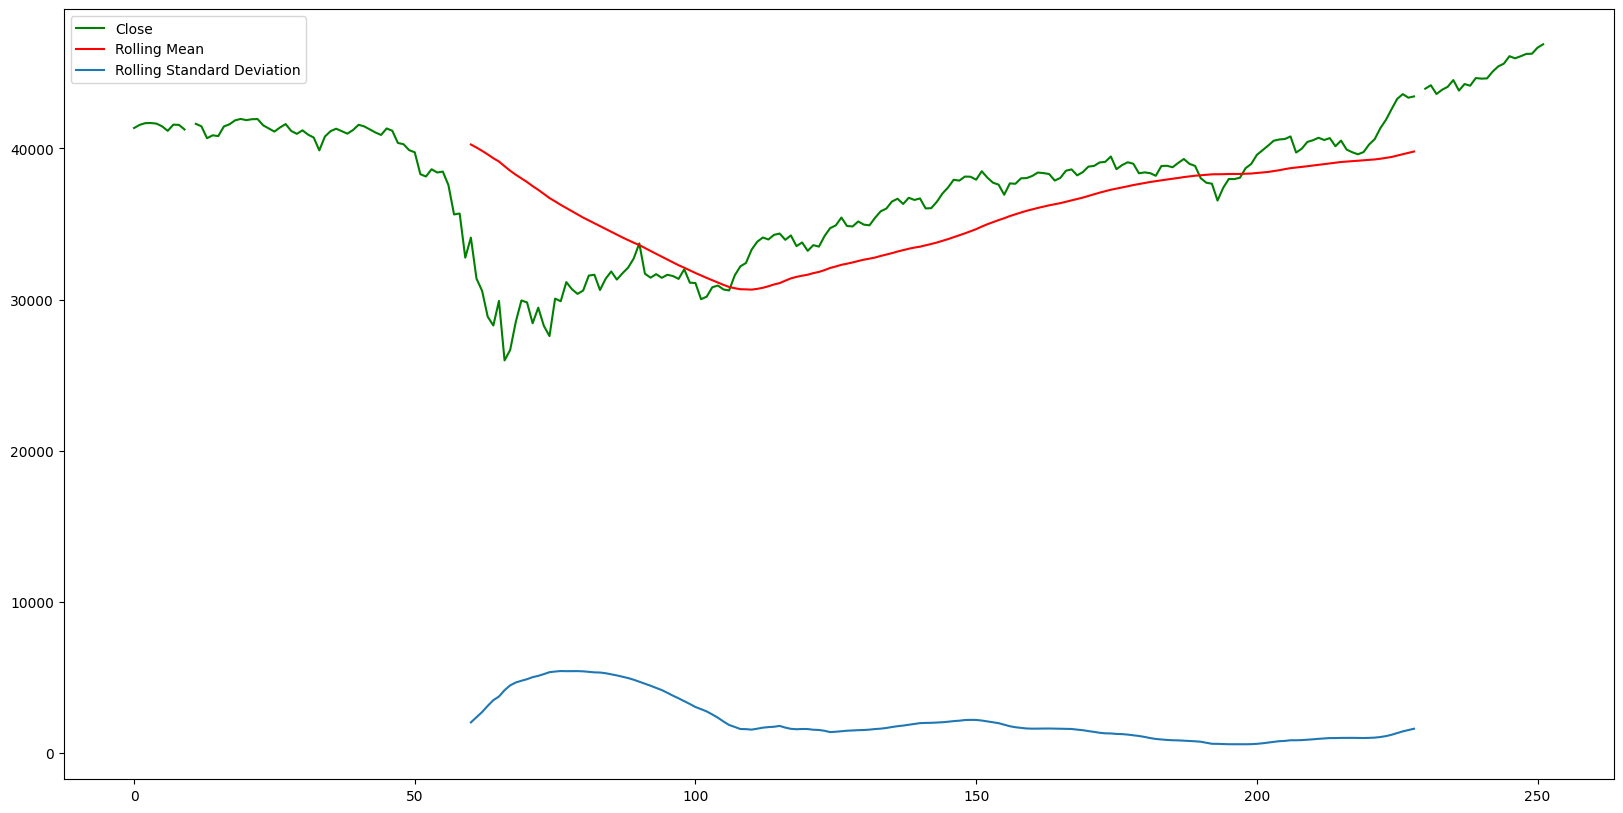

In [80]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

# Plot the Returns

Text(0.5, 1.0, 'Returns')

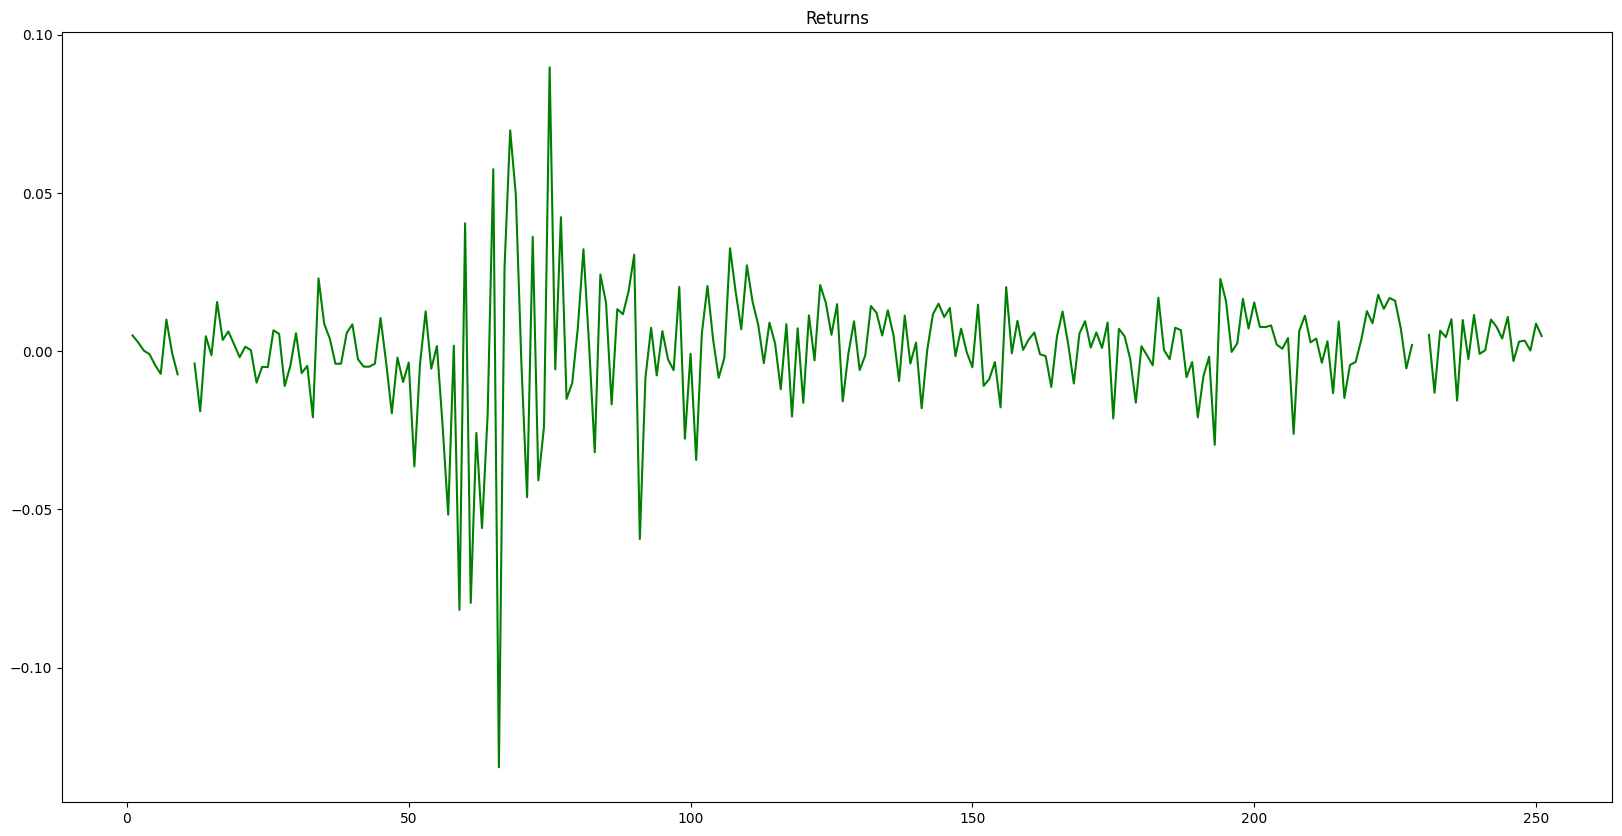

In [81]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [82]:

# Train test split
split_index = int(len(hisdf)*0.8)
train = hisdf[:split_index]
test = hisdf[split_index:]

# Rolling mean and Standard Deviation

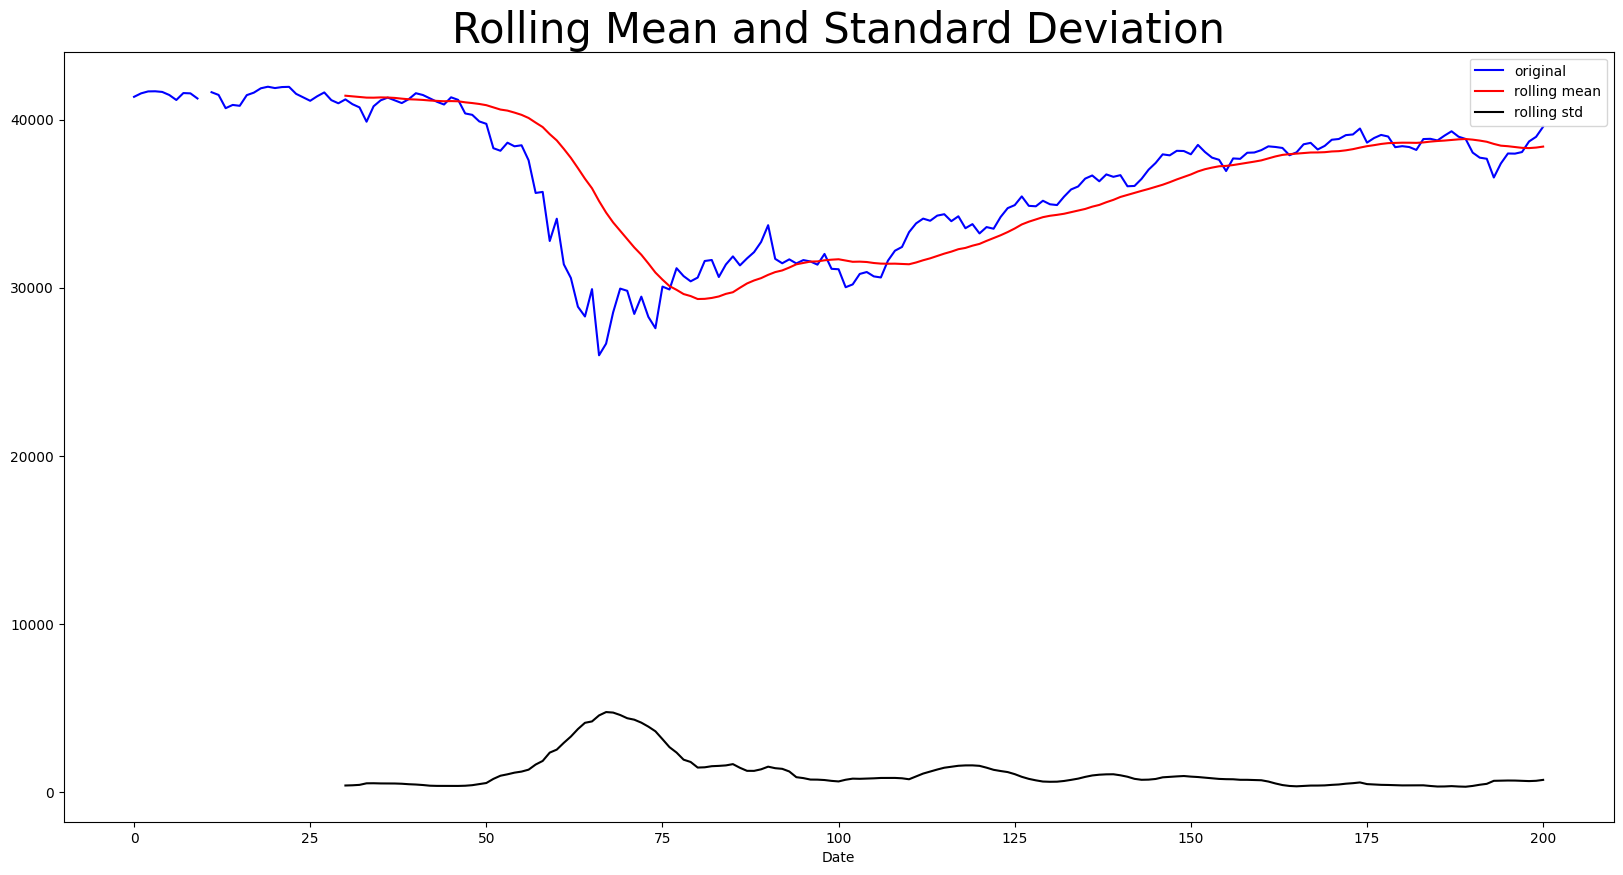

Results of dickey fuller test
ADF Test Statistic : -1.7041370608122794
p-value : 0.42898220915084856
#Lags Used : 7
Number of Observations Used : 192
Weak evidence against null hypothesis, time series is non-stationary 


In [83]:
#Stationarity test
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,10))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)

 # Handle missing or infinite values before applying the test
 timeseries = timeseries.dropna()  # Remove missing values
 timeseries = timeseries.replace([np.inf, -np.inf], np.nan).dropna()  # Replace infinite values with NaN and remove them

 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")

# Import necessary library
import numpy as np

test_stationarity(train['Close'])

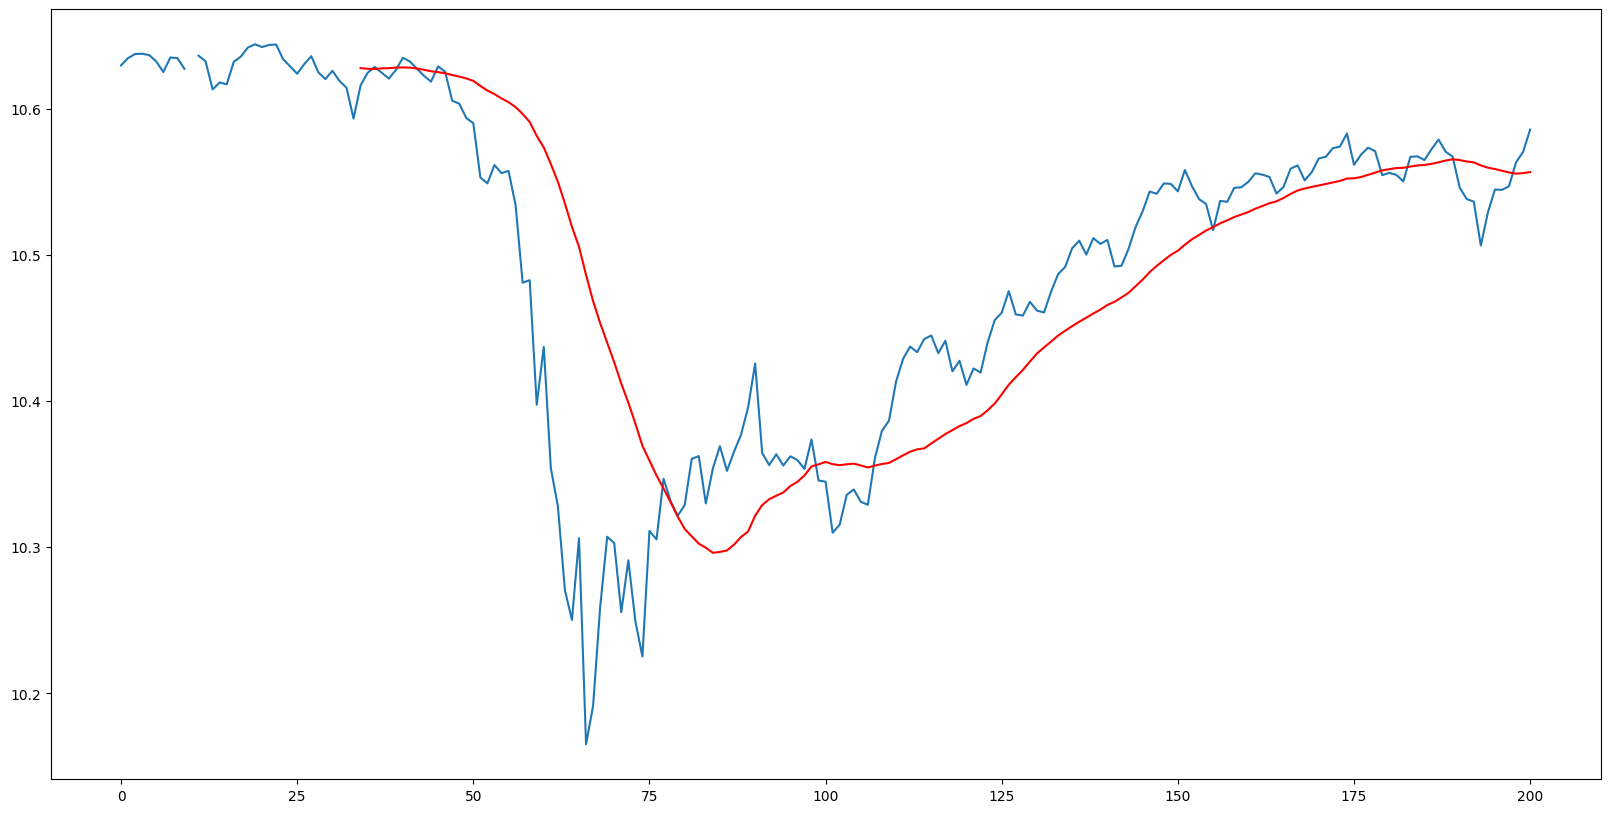

In [84]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize = (20,10))
plt.plot(train_log)
plt.plot(mav, color = 'red')

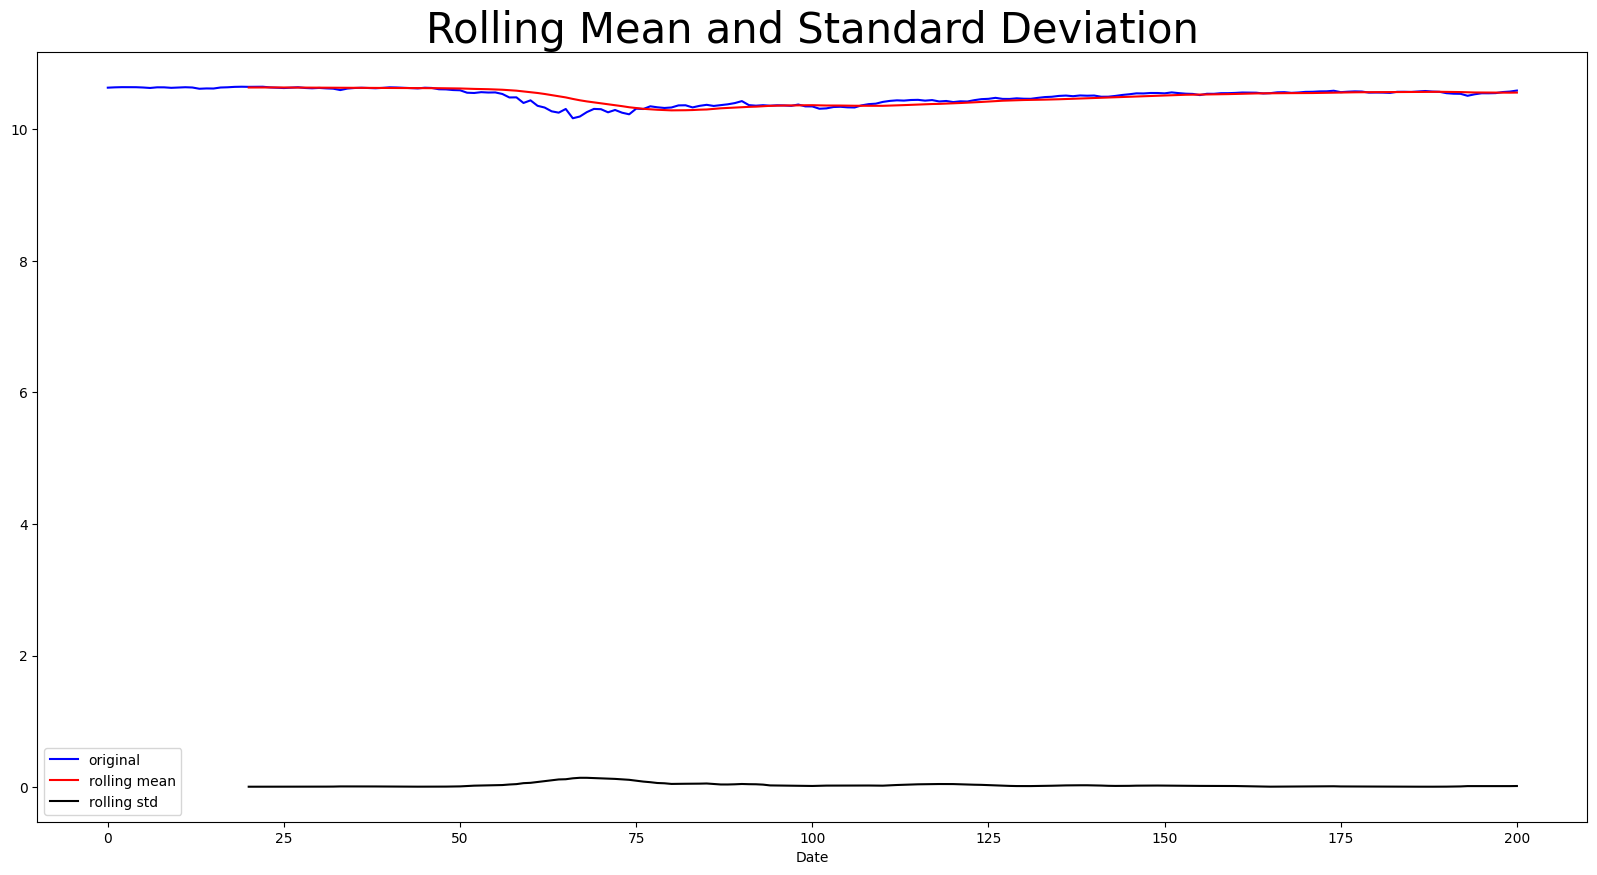

Results of dickey fuller test
ADF Test Statistic : -1.7670867442877793
p-value : 0.3969202480748387
#Lags Used : 7
Number of Observations Used : 192
Weak evidence against null hypothesis, time series is non-stationary 


In [85]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

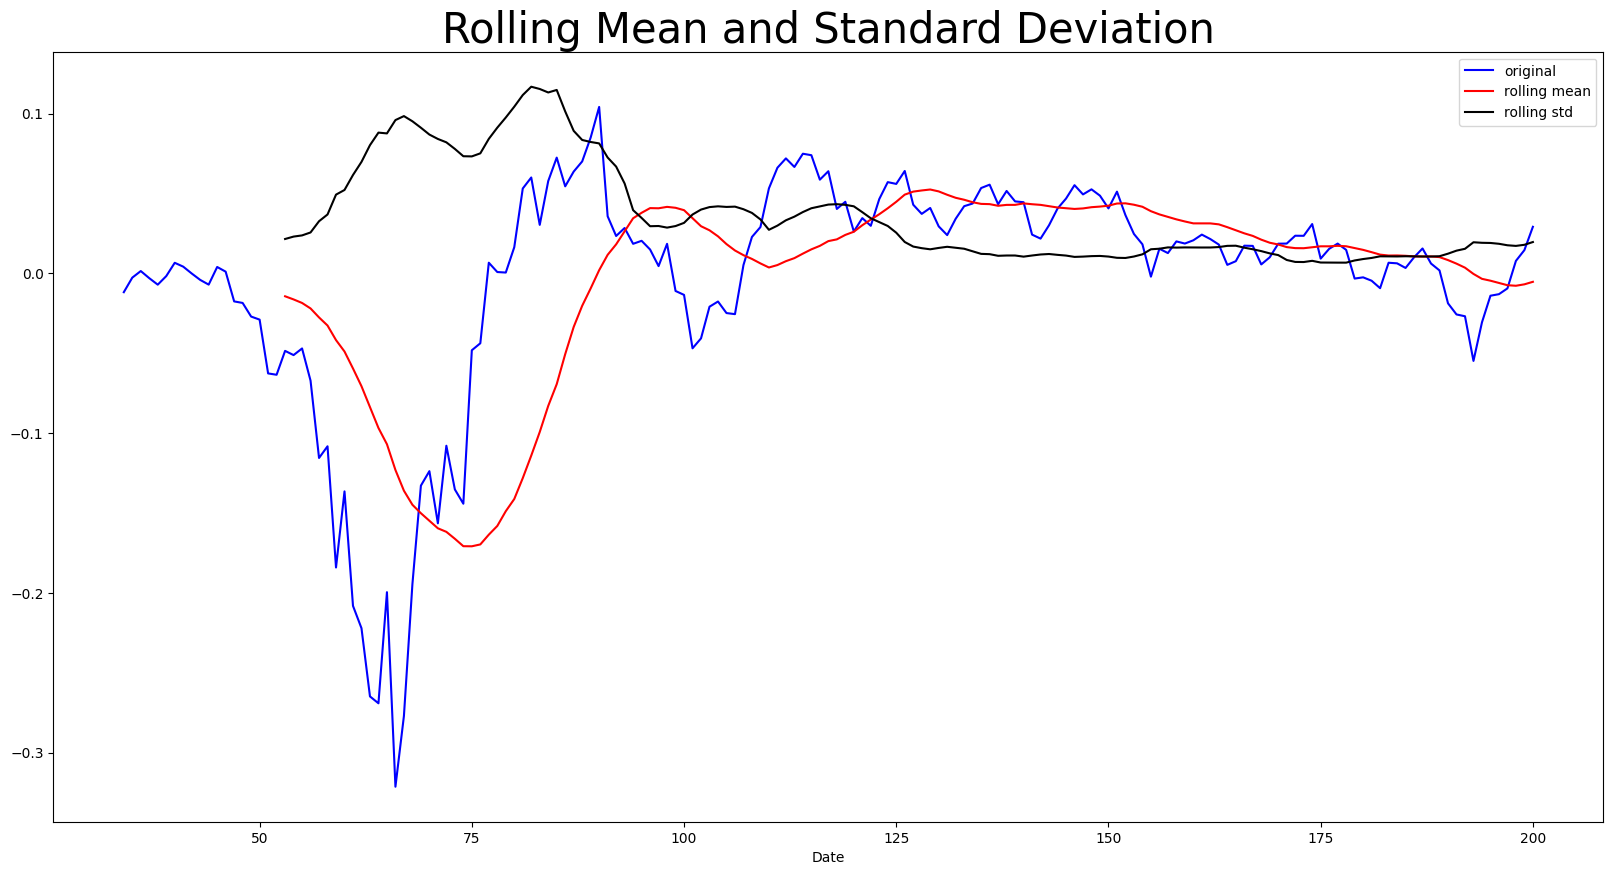

Results of dickey fuller test
ADF Test Statistic : -2.6820593494985605
p-value : 0.07719456896490084
#Lags Used : 7
Number of Observations Used : 159
Weak evidence against null hypothesis, time series is non-stationary 


In [86]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [48]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.6 MB/s eta 0:00:00


In [49]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima

In [87]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-944.299, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-945.044, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-947.753, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-947.292, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-947.025, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-945.939, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-945.837, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-944.031, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-949.723, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-947.912, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-947.809, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-949.262, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-946.005, Time=0.32 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.228 seconds


Text(0, 0.5, 'Actual Stock Price')

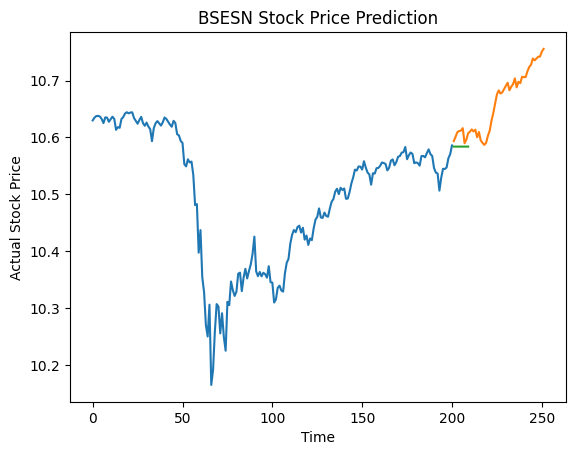

In [88]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

# Error Calculation

In [ ]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

# Textual Analysis

In [90]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [91]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,status quo disturbed ayodhya say vajpayee fiss...,0.269097,0.113889,-0.9792,0.121,0.809,0.071
1,2001-01-03,powerless north india grope dark think laxman ...,0.438462,0.065385,-0.8910,0.156,0.735,0.109
2,2001-01-04,string pulled stephen hawking india vajpayee g...,0.441656,0.073923,0.7543,0.104,0.792,0.104
3,2001-01-05,light combat craft take india club class hawki...,0.481766,0.268495,0.9645,0.142,0.694,0.164
4,2001-01-06,light combat craft take india club class hawki...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
8165,2023-06-26,loneliness worsen mental health spot three hid...,0.377107,0.025529,-0.9999,0.180,0.727,0.093
8166,2023-06-27,daily horoscope june read daily astrological p...,0.320945,0.038570,-1.0000,0.184,0.734,0.082
8167,2023-06-28,courting hut wedding ritual africa daily horos...,0.355165,0.027547,-0.9999,0.143,0.765,0.092
8168,2023-06-29,daily horoscope june read daily astrological p...,0.369061,0.021497,-0.9999,0.148,0.778,0.074


In [56]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

#Adding sentiment score to df_news
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [58]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Analyze the sentiment of a sample text
text = "I love programming with Python!"
sentiment = sia.polarity_scores(text)
print(sentiment)


{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.6696}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [93]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,status quo disturbed ayodhya say vajpayee fiss...,0.269097,0.113889,-0.9276,0.156,0.726,0.119
1,2001-01-03,powerless north india grope dark think laxman ...,0.438462,0.065385,-0.6908,0.174,0.678,0.148
2,2001-01-04,string pulled stephen hawking india vajpayee g...,0.441656,0.073923,0.8126,0.130,0.735,0.134
3,2001-01-05,light combat craft take india club class hawki...,0.481766,0.268495,0.9180,0.176,0.631,0.193
4,2001-01-06,light combat craft take india club class hawki...,0.439394,0.248485,-0.8316,0.231,0.628,0.142
...,...,...,...,...,...,...,...,...
8165,2023-06-26,loneliness worsen mental health spot three hid...,0.377107,0.025529,-0.9999,0.193,0.699,0.108
8166,2023-06-27,daily horoscope june read daily astrological p...,0.320945,0.038570,-0.9999,0.188,0.721,0.091
8167,2023-06-28,courting hut wedding ritual africa daily horos...,0.355165,0.027547,-0.9997,0.155,0.739,0.106
8168,2023-06-29,daily horoscope june read daily astrological p...,0.369061,0.021497,-0.9999,0.170,0.738,0.092


# Merge the Historical and Textual Data

In [94]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0,jagannath temple puri beach devpt plan offing ...,0.347471,0.011569,-0.9999,0.207,0.704,0.089
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0,citizenship amendment bill need know r crore g...,0.378780,0.029892,-0.9999,0.181,0.721,0.098
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0,cca covered revamp canal cag performing bengal...,0.365890,0.016303,-0.9999,0.182,0.717,0.101
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0,im done playing good girl want baddie amrita r...,0.356880,0.033717,-0.9999,0.180,0.724,0.096
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0,weekly horoscope december check prediction zod...,0.402187,0.023089,-0.9997,0.171,0.717,0.113
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,26300.0,way get mood sex youre really feeling crackdow...,0.373347,0.055703,-0.9998,0.169,0.733,0.098
248,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,18400.0,threat covid claim balance sheet petrol would ...,0.363573,0.051199,-0.9995,0.154,0.734,0.112
249,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,16400.0,rt pcr test day found akola pay compensation f...,0.359396,0.037092,-0.9998,0.157,0.743,0.100
250,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,13100.0,asmita soods favourite holiday destination eve...,0.417234,0.040876,-0.9998,0.162,0.737,0.100


# Create Dataset for Model Training

In [95]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,41352.171875,0.347471,0.011569,-0.9999,0.207,0.704,0.089
1,41558.570313,0.378780,0.029892,-0.9999,0.181,0.721,0.098
2,41673.921875,0.365890,0.016303,-0.9999,0.182,0.717,0.101
3,41681.539063,0.356880,0.033717,-0.9999,0.180,0.724,0.096
4,41642.660156,0.402187,0.023089,-0.9997,0.171,0.717,0.113
...,...,...,...,...,...,...,...
247,46099.011719,0.373347,0.055703,-0.9998,0.169,0.733,0.098
248,46253.460938,0.363573,0.051199,-0.9995,0.154,0.734,0.112
249,46263.171875,0.359396,0.037092,-0.9998,0.157,0.743,0.100
250,46666.460938,0.417234,0.040876,-0.9998,0.162,0.737,0.100


# Normalize Data

In [96]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.735131,0.209106,0.121610,0.011236,0.886364,0.166667,0.250000
1,0.745002,0.513412,0.284918,0.011236,0.590909,0.369048,0.368421
2,0.750519,0.388133,0.163803,0.011236,0.602273,0.321429,0.407895
3,0.750884,0.300564,0.319006,0.011236,0.579545,0.404762,0.342105
4,0.749024,0.740916,0.224283,0.033708,0.477273,0.321429,0.565789


In [97]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.209106,0.121610,0.011236,0.886364,0.166667,0.250000
1,0.513412,0.284918,0.011236,0.590909,0.369048,0.368421
2,0.388133,0.163803,0.011236,0.602273,0.321429,0.407895
3,0.300564,0.319006,0.011236,0.579545,0.404762,0.342105
4,0.740916,0.224283,0.033708,0.477273,0.321429,0.565789
...,...,...,...,...,...,...
247,0.460610,0.514966,0.022472,0.454545,0.511905,0.368421
248,0.365611,0.474824,0.056180,0.284091,0.523810,0.552632
249,0.325014,0.349093,0.022472,0.318182,0.630952,0.394737
250,0.887174,0.382813,0.022472,0.375000,0.559524,0.394737


In [98]:
Y=df['Close']
Y

,Close
0,0.735131
1,0.745002
2,0.750519
3,0.750884
4,0.749024
5,0.740349
6,0.726120
7,0.745795
8,0.744975
9,0.730424


# Split the Dataset into Train & Test Data

In [99]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(201, 6)

In [100]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
162,0.506164,0.497804,0.011236,0.522727,0.440476,0.381579
159,0.284385,0.173383,0.011236,0.602273,0.404762,0.302632
76,0.499456,0.536027,0.044944,0.272727,0.702381,0.368421
59,0.750208,0.118003,0.011236,0.863636,0.095238,0.355263
176,0.511558,0.326924,0.022472,0.443182,0.547619,0.342105
229,0.951845,0.867832,0.101124,0.375000,0.142857,0.881579
18,0.280713,0.709317,0.022472,0.625000,0.178571,0.539474
221,0.578880,0.441515,0.033708,0.238636,0.750000,0.355263
15,0.619803,0.424764,0.011236,0.556818,0.440476,0.328947
152,0.568795,0.223506,0.022472,0.352273,0.654762,0.315789


# RandomForestRegressor Model

In [109]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)


In [110]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.63783292 0.440247   0.61606194 0.65965989 0.48112579 0.67888955
 0.54471524 0.33492665 0.59442539 0.59144751]
158    0.576027
83     0.222653
170    0.613027
101    0.193587
150    0.571688
199    0.621378
118    0.361428
227    0.831023
63     0.138135
135    0.502463
Name: Close, dtype: float64
Mean Squared error:  0.04411987690460373


# DecisionTreeRegressor Model

In [111]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [112]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.52409532 0.72570704 0.74535291 0.66467276 0.59838583 0.72612029
 0.65200465 0.18965567 0.87418867 0.38258266]
158    0.576027
83     0.222653
170    0.613027
101    0.193587
150    0.571688
199    0.621378
118    0.361428
227    0.831023
63     0.138135
135    0.502463
Name: Close, dtype: float64
Mean Squared error:  0.0871755693090768


# AdaBoostRegressor Model

In [113]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [114]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.041329134893012834


# LGBMRegressor Model

In [115]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 201, number of used features: 6
[LightGBM] [Info] Start training from score 0.563802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor()

In [116]:
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.03986778704371765


# XGBRegressor Model

In [117]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [118]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.04301500905583547


# Conclusion

- RandomForest = 0.05257968397499098
- DecisionTree = 0.10831900809236311
- AdaBoost = 0.05492347045438241
- LightGBM = 0.0583079056070462
- XGBoost = 0.05968830860645931
From here we can see that RandomForestRegressor shows a better performance than the others